In [6]:
%load_ext autoreload
%autoreload 2
from MANO import mano
import numpy as np
import torch
from MANO.smplx.smplx.lbs import batch_rodrigues
%matplotlib widget
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0, 0.5, 'y')

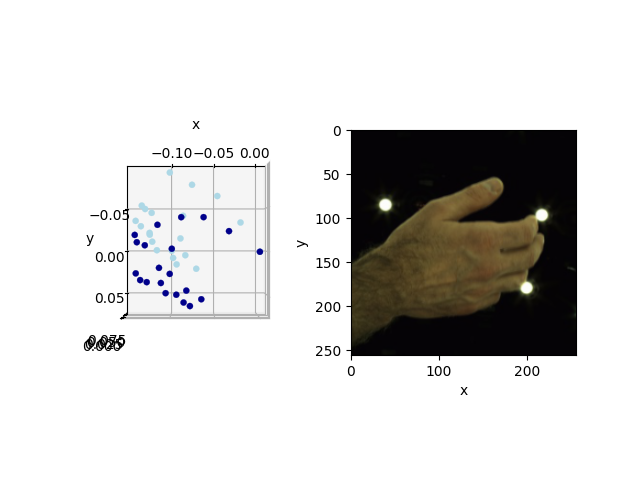

In [ ]:
faces = mano.layer['right'].faces
hand = 'left'
num = '1'
path = f'example_{hand}hand{num}/'
# path = ''
mesh_gt = np.loadtxt(f'{path}gt_mesh.txt')
mesh_pred = np.loadtxt(f'{path}pred_mesh.txt')
joint_gt = np.loadtxt(f'{path}gt_joint.txt')
joint_pred = np.loadtxt(f'{path}pred_joint.txt')
img = np.loadtxt(f'{path}img.txt').reshape(3, 256, 256).transpose(1, 2, 0)

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)
ax1.plot_trisurf(mesh_gt[:, 0], mesh_gt[:, 1], mesh_gt[:, 2], triangles=faces, color='lightblue', edgecolor='gray', linewidth=0.2, alpha=0.5)
ax1.plot_trisurf(mesh_pred[:, 0], mesh_pred[:, 1], mesh_pred[:, 2], triangles=faces, color='darkblue', edgecolor='gray', linewidth=0.2, alpha=0.5)

# ax1.scatter(joint_gt[:, 0], joint_gt[:, 1], joint_gt[:, 2], color='lightblue', linewidth=0.2, alpha=1)
# ax1.scatter(joint_pred[:, 0], joint_pred[:, 1], joint_pred[:, 2], color='darkblue', linewidth=0.2, alpha=1)
ax1.set_aspect('equal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
# ax1.invert_xaxis()
# ax1.invert_yaxis()
ax1.view_init(-90, -90)
ax2.imshow(img)
ax2.set_xlabel('x')
ax2.set_ylabel('y')

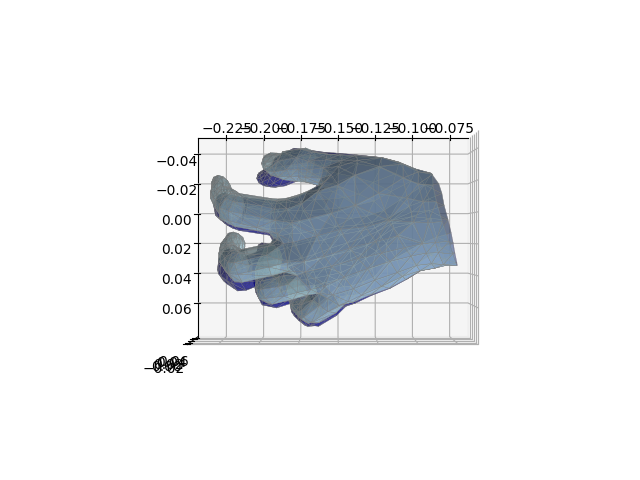

In [9]:
faces = mano.layer['right'].faces
pose_gt = np.loadtxt(f'{path}gt_pose.txt')[None]
pose_pred = np.loadtxt(f'{path}pred_pose.txt')[None]
outputs = mano.layer['right'](betas = torch.zeros([1, 10]).float(), global_orient = torch.from_numpy(pose_gt[:,:3]).float(),hand_pose = torch.from_numpy(pose_gt[:,3:]).float())
mesh_gtgt = outputs.vertices[0]
outputs = mano.layer['right'](betas = torch.zeros([1, 10]).float(), global_orient = torch.from_numpy(pose_pred[:,:3]).float(),hand_pose = torch.from_numpy(pose_pred[:,3:]).float())
# outputs = mano.layer['right'](betas = torch.zeros([1, 10]).float(), global_orient = torch.from_numpy(pose_gt[:,:3]).float(),hand_pose = torch.from_numpy(pose_gt[:,3:]).float())
mesh_predpred = outputs.vertices[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mesh_gtgt[...,0] *=-1
mesh_predpred[...,0] *=-1
ax.plot_trisurf(mesh_gtgt[:, 0], mesh_gtgt[:, 1], mesh_gtgt[:, 2], triangles=faces, color='lightblue', edgecolor='gray', linewidth=0.2, alpha=0.5)
ax.plot_trisurf(mesh_predpred[:, 0], mesh_predpred[:, 1], mesh_predpred[:, 2], triangles=faces, color='darkblue', edgecolor='gray', linewidth=0.2, alpha=0.5)
ax.set_aspect('equal')
ax.view_init(-90,-90)

In [ ]:
# pose = torch.zeros(1, 48)
pose = torch.rand(1, 48)
pose_rot = batch_rodrigues(pose.reshape(-1, 3))[None]   # eular to rot
faces = mano.layer['right'].faces

In [18]:
pose_rot.shape

torch.Size([1, 16, 3, 3])

In [ ]:
def rot2aa(mat, eps=1e-8):
    ### mat: [..., 3, 3]
    batch_shape = mat.shape[:-2]
    mat = mat.reshape(-1, 3, 3)
    tr = torch.tensor([torch.trace(m) for m in mat])
    theta = torch.arccos((tr-1)/2)
    sin = torch.sin(theta)

    aa = torch.stack([
        (mat[...,2,1]-mat[...,1,2]) / (2*sin+eps), 
        (mat[...,0,2]-mat[...,2,0]) / (2*sin+eps), 
        (mat[...,1,0]-mat[...,0,1]) / (2*sin+eps), 
    ], dim=-1)
    # print(torch.sum(aa*aa, -1))
    aa = (theta.unsqueeze(-1)*aa).reshape(*batch_shape, 3)
    return aa
aa = rot2aa(pose_rot)
pose_aa = aa.reshape(-1, 48)
torch.allclose(pose_aa, pose)


True

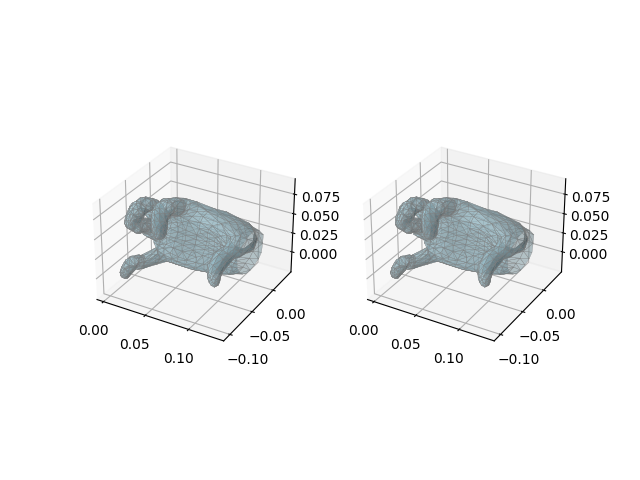

In [5]:
# pose = torch.eye(3)[None,None].repeat(1, 16, 1, 1)
shape = torch.zeros(1, 10)
idx = 14
# pose[0, 3*idx:3*idx+3] = 1
outputs = mano.layer['right'](betas = shape, global_orient = pose_aa[:,:3],hand_pose = pose_aa[:,3:])
vertices_rot = outputs.vertices[0]
# joint = torch.matmul(torch.from_numpy(mano.joint_regressor), vertices_rot)

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')

# ax.scatter(*joint[17], color='red', s=50)
ax.plot_trisurf(vertices_rot[:, 0], vertices_rot[:, 1], vertices_rot[:, 2], triangles=faces, color='lightblue', edgecolor='gray', linewidth=0.2, alpha=0.5)

outputs = mano.layer['right'](betas = shape, global_orient = pose[:,:3],hand_pose = pose[:,3:])
vertices_aa = outputs.vertices[0]
# joint = torch.matmul(torch.from_numpy(mano.joint_regressor), vertices_aa)

ax = fig.add_subplot(122, projection='3d')

# ax.scatter(*joint[17], color='red', s=50)
ax.plot_trisurf(vertices_aa[:, 0], vertices_aa[:, 1], vertices_aa[:, 2], triangles=faces, color='lightblue', edgecolor='gray', linewidth=0.2, alpha=0.5)

(array([251., 156., 126., 104.,   7.,  67.,  29.,  29.,   5.,   4.]),
 array([0.00000000e+00, 2.98023228e-09, 5.96046457e-09, 8.94069707e-09,
        1.19209291e-08, 1.49011612e-08, 1.78813941e-08, 2.08616253e-08,
        2.38418583e-08, 2.68220894e-08, 2.98023224e-08]),
 <BarContainer object of 10 artists>)

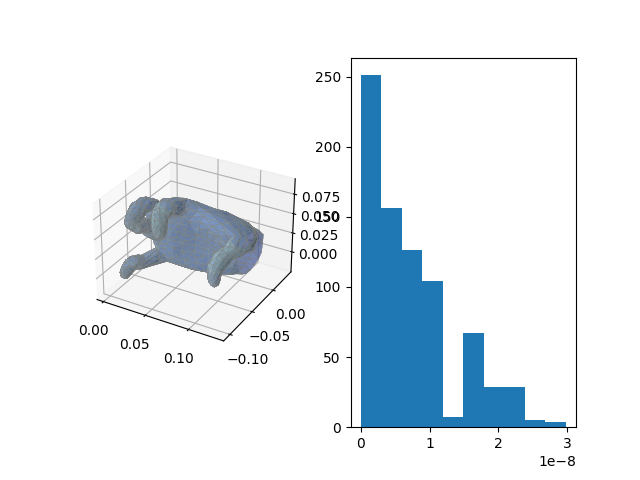

In [7]:
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(vertices_aa[:, 0], vertices_aa[:, 1], vertices_aa[:, 2], triangles=faces, color='lightblue', edgecolor='gray', linewidth=0.2, alpha=0.5)
ax.plot_trisurf(vertices_rot[:, 0], vertices_rot[:, 1], vertices_rot[:, 2], triangles=faces, color='blue', edgecolor='gray', linewidth=0.2, alpha=0.5)

diff_v = torch.abs(vertices_aa - vertices_rot).sum(-1)

ax = fig.add_subplot(122)
ax.hist(diff_v)

In [8]:
euler_coordtrans_RIGHT = np.array([
       [   0,  -6,  10,
           0,   1,  -5,
           0, -10,   0,
           0,  10,   2,
           0,  10,  -2,
           0,  10,  10,
          30,  35,  10,
          20,  42,   8,
          15,  45,   8,
           0,  12,   5,
           0,  25,  -5,
           0,  25,  15,
          30, -75, -35,
          20, -45, -30,
          20, -45, -30]]) / 180 * np.pi

def coordtrans(rotmat, local2global, transtype):

    batchsize = rotmat.shape[0]
    local2global = local2global.clone()
    if transtype == 1:
        rotmat[:,1:] = torch.einsum('...ij,...jk->...ik', rotmat[:,1:], local2global[:batchsize])
        rotmat[:,1:] = torch.einsum('...ij,...jk->...ik', local2global[:batchsize].transpose(2,3), rotmat[:,1:])
    else:
        rotmat[:,1:] = torch.einsum('...ij,...jk->...ik', rotmat[:,1:], local2global[:batchsize].transpose(2,3))
        rotmat[:,1:] = torch.einsum('...ij,...jk->...ik', local2global[:batchsize], rotmat[:,1:])

    return rotmat

def batch_euler2matzxy(angle):
    """
    Convert euler angles to rotation matrix.
    Args:
        angle: [N, 3], rotation angle along 3 axis (in radians)
    Returns:
        Rotation: [N, 3, 3], matrix corresponding to the euler angles
    """
    # obtain the batch size
    B = angle.size(0)
    x, y, z = angle[:,0], angle[:,1], angle[:,2]

    cosz = torch.cos(z)
    sinz = torch.sin(z)

    zeros = z.detach()*0
    ones = zeros.detach()+1
    zmat = torch.stack([cosz, -sinz, zeros,
                        sinz,  cosz, zeros,
                        zeros, zeros,  ones], dim=1).reshape(B, 3, 3)

    cosy = torch.cos(y)
    siny = torch.sin(y)

    ymat = torch.stack([cosy, zeros,  siny,
                        zeros,  ones, zeros,
                        -siny, zeros,  cosy], dim=1).reshape(B, 3, 3)

    cosx = torch.cos(x)
    sinx = torch.sin(x)

    xmat = torch.stack([ones, zeros, zeros,
                        zeros,  cosx, -sinx,
                        zeros,  sinx,  cosx], dim=1).reshape(B, 3, 3)

    rotMat = ymat @ xmat @ zmat
    return rotMat

local2global = batch_euler2matzxy(torch.from_numpy(euler_coordtrans_RIGHT).view(-1, 3))[None].float()
print(local2global.shape)

torch.Size([1, 15, 3, 3])


torch.Size([1, 16, 3, 3]) torch.Size([1, 16, 3, 3])


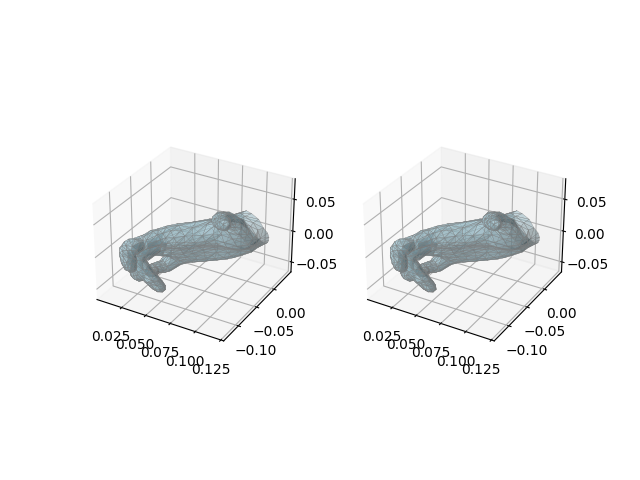

In [9]:
pred_pose_mean = torch.rand(1, 16, 3)
pred_pose_rotmat_mean_local = batch_euler2matzxy(pred_pose_mean.reshape(-1,3)).view(-1,16,3,3)
pred_pose_rotmat_mean_global = coordtrans(pred_pose_rotmat_mean_local, local2global, 1)
print(pred_pose_rotmat_mean_local.shape, pred_pose_rotmat_mean_global.shape)
pred_pose_aa_local = rot2aa(pred_pose_rotmat_mean_local).reshape(-1, 48)
pred_pose_aa_global = rot2aa(pred_pose_rotmat_mean_global).reshape(-1, 48)
outputs = mano.layer['right'](betas = shape, global_orient = pred_pose_aa_local[:,:3],hand_pose = pred_pose_aa_local[:,3:])
pred_v_local = outputs.vertices[0]
outputs = mano.layer['right'](betas = shape, global_orient = pred_pose_aa_global[:,:3],hand_pose = pred_pose_aa_global[:,3:])
pred_v_global = outputs.vertices[0]

fig = plt.figure()

ax = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(pred_v_local[:, 0], pred_v_local[:, 1], pred_v_local[:, 2], triangles=faces, color='lightblue', edgecolor='gray', linewidth=0.2, alpha=0.5)
ax = fig.add_subplot(122, projection='3d')
ax.plot_trisurf(pred_v_global[:, 0], pred_v_global[:, 1], pred_v_global[:, 2], triangles=faces, color='lightblue', edgecolor='gray', linewidth=0.2, alpha=0.5)

In [10]:
torch.allclose(pred_v_local, pred_v_global)#,\
# torch.allclose(pred_pose_aa_local, pred_pose_aa_global),\
# torch.allclose(pred_pose_rotmat_mean_local, pred_pose_rotmat_mean_global)

True

In [11]:
import torch
from torch import nn, Tensor
##############
# modified from https://github.com/zhangy76/KNOWN-Hand/blob/main/losses.py
##############

pi = torch.pi

BOF_RIGHT = torch.tensor([
       [ -179,-179,-179,
           0, -40, -30,
           0,   0,   0,
           0,   0, -45,
           0, -20, -20,
           0,   0,   0,
           0,   0, -20,
           0, -10, -30,
           0,   0,   0,
           0,   0, -40,
           0, -20, -20,
           0,   0,   0,
           0,   0, -10,
           0, -90, -45,
           0,-100,   0,
           0, -90,   0],
        [179, 179, 179,
           0,   5,  90,
           0,   0, 110,
           0,   0,  90,
           0,  15, 100,
           0,   0, 110,
           0,   0,  85,
           0,  45, 100,
           0,   0, 100,
           0,   0,  90,
           0,  20,  90,
           0,   0, 110,
           0,   0,  80,
           0,  20,  45,
           0,   0,   0,
           0,  45,   0]]) / 180 * pi

class BioFeasiblityLoss(nn.Module):
   def __init__(self,):
      super().__init__()
      self.register_buffer('max_angle', None, persistent=False)
      self.register_buffer('min_angle', None, persistent=False)
      self.max_angle = BOF_RIGHT[1]    # [16*3]
      self.min_angle = BOF_RIGHT[0]    # [16*3]


   def forward(self, pose_eular):
      # pose: [..., 48]
      # update joint range of motion given different joint angles using the function anatomy knowledge
      data_shape = pose_eular.shape[:-1]
      pose_eular = pose_eular.reshape(-1, 48) # [B, 48]

      lower_bound, upper_bound = self.compute_angle_bound(pose_eular.detach())    # [B, 48]

      pose_eular_bound = torch.clamp(pose_eular, lower_bound, upper_bound).reshape(*data_shape, 48)
      # print("lower")
      # print(lower_bound[0])
      # print("upper")
      # print(upper_bound[0])

      return pose_eular_bound
    
   def compute_angle_bound(self, pose_eular: Tensor):
      # pose_eular: [B, 48]
      B, _ = pose_eular.shape
      
      upper = self.max_angle[None].expand(B, -1)
      lower = self.min_angle[None].expand(B, -1)
      
      pose_bound = pose_eular.clone()
      upper_bound = upper.clone()
      lower_bound = lower.clone()

      pose_bound = torch.maximum(pose_bound, lower_bound)
      pose_bound = torch.minimum(pose_bound, upper_bound)

      # eular angle [beta, gamma, alpha]  (twist, splay, bend)?
      # alpha bound of DIP conditioned on PIP
      DIP_index = [11,20,38,29]   # the alpha angle of the [4,7,13,10]-th joints
      PIP_index = [8,17,35,26]    # the alpha angle of the [3,6,12,9]-th joints
      lower_bound[:,PIP_index] = torch.where(lower_bound[:,DIP_index]>0, 0, lower_bound[:,PIP_index])   # use `.where` as fancy indexing returns a view

      # MCP joint fingers
      MCP_index_beta = [4,13,31,22] # MCP, the [2,5,11,8]-th joints
      MCP_index_gamma = [5,14,32,23]
      lower_bound[:,MCP_index_beta] = lower_bound[:,MCP_index_beta] * (1 - (pose_bound[:,MCP_index_gamma].clamp(max=70/180*pi)/(70/180*pi)))
      upper_bound[:,MCP_index_beta] = upper_bound[:,MCP_index_beta] * (1 - (pose_bound[:,MCP_index_gamma].clamp(max=70/180*pi)/(70/180*pi)))

      # MCP thumb
      MCP_thumb_beta = 40 # the 14-th joint
      MCP_thumb_gamma = 41
      lower_bound[:,MCP_thumb_beta] = lower_bound[:,MCP_thumb_beta] * (1 - (pose_bound[:,MCP_thumb_gamma].clamp(max=70/180*pi)/(70/180*pi)))
      upper_bound[:,MCP_thumb_beta] = upper_bound[:,MCP_thumb_beta] * (1 - (pose_bound[:,MCP_thumb_gamma].clamp(max=70/180*pi)/(70/180*pi)))

      # eliminate new bound that are outside the original bound
      lower_bound = torch.maximum(lower_bound, lower)
      upper_bound = torch.minimum(upper_bound, upper)

      return lower_bound, upper_bound

def eular2aa(eular):
   # eular: [B, J, 3]
   B, J, _ = eular.shape
   rot = batch_euler2matzxy(eular.flatten(0, 1))   # [BJ, 3, 3]
   aa = rot2aa(rot).reshape(B, J, -1)  # [B, J, 3]
   return aa.flatten(1)


In [12]:
pose_eular = pose_eular # keeps current number

NameError: name 'pose_eular' is not defined

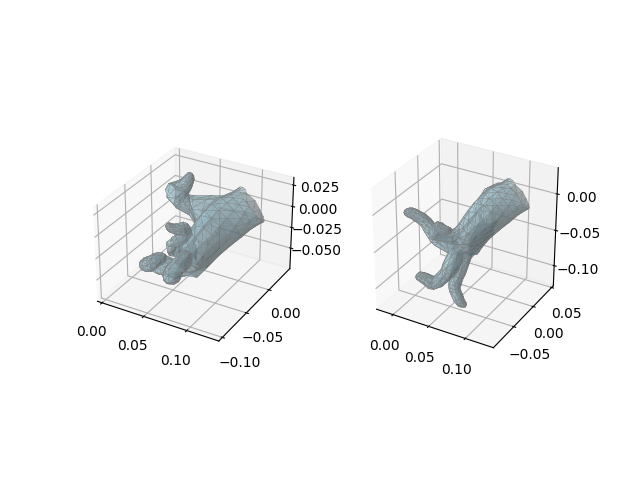

In [84]:
K, B, T, J, = 4, 24, 3, 16, 
shape = torch.zeros(K*B*T, 10)
pose_eular = torch.rand(K, B, T, J, 3)*5-5/2
# pose_eular = torch.zeros(K, B, T, J, 3)
data_shape = pose_eular.shape[:-2]
pose_eular = pose_eular.flatten(0, -3)
pose_unbounded = eular2aa(pose_eular) # [KBT, J3]
pose_bounded = eular2aa(BioFeasiblityLoss()(pose_eular.flatten(1)).reshape(-1, 16, 3))

outputs = mano.layer['right'](betas = shape, global_orient = pose_unbounded[:,:3],hand_pose = pose_unbounded[:,3:])
vertices_unbounded = outputs.vertices[0]
outputs = mano.layer['right'](betas = shape, global_orient = pose_bounded[:,:3],hand_pose = pose_bounded[:,3:])
vertices_bounded = outputs.vertices[0]


fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(vertices_unbounded[:, 0], vertices_unbounded[:, 1], vertices_unbounded[:, 2], triangles=faces, color='lightblue', edgecolor='gray', linewidth=0.2, alpha=0.5)
ax.set_aspect('equal')
ax = fig.add_subplot(122, projection='3d')
ax.plot_trisurf(vertices_bounded[:, 0], vertices_bounded[:, 1], vertices_bounded[:, 2], triangles=faces, color='lightblue', edgecolor='gray', linewidth=0.2, alpha=0.5)
ax.set_aspect('equal')
# print(f"unbounded: {pose_unbounded[0].shape}")
# print(pose_unbounded[0])
# print(f"bounded: {pose_bounded[0].shape}")
# print(pose_bounded[0])

In [17]:
(pose_eular.abs()>torch.pi/2).any()

tensor(True)

In [24]:
import torchgeometry as tgm
def rot2aa2(rot):
    B = rot.shape[0]
    rot_mat = torch.cat([rot,torch.zeros((B,3,1)).to(rot.device).float()],2) # 3x4 rotation matrix
    axis_angle = tgm.rotation_matrix_to_angle_axis(rot_mat).reshape(-1,3) # axis-angle
    axis_angle[torch.isnan(axis_angle)] = 0.0
    return axis_angle

def rot2aa(mat, eps=1e-8):
    ### mat: [..., 3, 3]
    batch_shape = mat.shape[:-2]
    mat = mat.reshape(-1, 3, 3)
    tr = torch.tensor([torch.trace(m) for m in mat])
    theta = torch.arccos((tr-1)/2)
    sin = torch.sin(theta)

    aa = torch.stack([
        (mat[...,2,1]-mat[...,1,2]) / (2*sin+eps), 
        (mat[...,0,2]-mat[...,2,0]) / (2*sin+eps), 
        (mat[...,1,0]-mat[...,0,1]) / (2*sin+eps), 
    ], dim=-1)
    # print(torch.sum(aa*aa, -1))
    aa = (theta.unsqueeze(-1)*aa).reshape(*batch_shape, 3)
    return aa

mats = torch.rand([5, 3, 3])

err = (rot2aa(mats) - rot2aa2(mats)).abs()
rot2aa2(mats), rot2aa(mats)

(tensor([[ 0.1802,  0.0519, -0.0780],
         [ 0.1590,  0.1247, -0.1065],
         [-0.1475,  0.6811, -0.0323],
         [ 0.0136,  0.1494, -0.3367],
         [-0.4955,  0.0530,  0.7898]]),
 tensor([[ 0.1596,  0.0460, -0.0691],
         [ 0.1403,  0.1100, -0.0939],
         [-0.1324,  0.6116, -0.0290],
         [ 0.0102,  0.1122, -0.2530],
         [-0.4282,  0.0458,  0.6826]]))

In [75]:
def eular2aa(eular):
   # eular: [B, J, 3]
   B, J, _ = eular.shape
   rot = batch_euler2matzxy(eular.flatten(0, 1))   # [BJ, 3, 3]
   aa = rot2aa(rot).reshape(B, J, -1)  # [B, J, 3]
   return aa.flatten(1)
def eular2aa2(eular):
   # eular: [B, J, 3]
   B, J, _ = eular.shape
   rot = batch_euler2matzxy(eular.flatten(0, 1))   # [BJ, 3, 3]
   rot_mat = torch.cat([rot,torch.zeros((B*J,3,1)).to(rot.device).float()],2) # 3x4 rotation matrix
   axis_angle = tgm.rotation_matrix_to_angle_axis(rot_mat).reshape(-1,3) # axis-angle
   axis_angle[torch.isnan(axis_angle)] = 0.0
   aa = axis_angle.reshape(B, -1)  # [B, J, 3]
   return aa

eular = torch.rand(4, 2, 3)*5
aa1, rot1 = eular2aa(eular)
aa2, rot2 = eular2aa2(eular)
torch.allclose(aa1, aa2), (aa1-aa2).abs().max()

ValueError: too many values to unpack (expected 2)

In [63]:
aa1, aa2

(tensor([[ 0.5358,  2.0391, -1.9467,  0.5967, -1.5952,  1.3021],
         [ 0.9029,  1.3430, -1.0733,  2.5798, -0.1846, -1.4032],
         [ 2.2212,  0.5893,  1.0936, -1.0118,  0.6849,  0.8531],
         [-0.0843, -2.0521,  1.6836, -0.8005,  1.9752,  2.2977]]),
 tensor([[ 0.5358,  2.0391, -1.9467,  0.5967, -1.5952,  1.3021],
         [ 0.9029,  1.3430, -1.0733,  2.5798, -0.1846, -1.4032],
         [ 2.2213,  0.5893,  1.0936, -1.0118,  0.6849,  0.8531],
         [-0.0843, -2.0521,  1.6836, -0.8000,  1.9740,  2.2963]]))

In [66]:
rot1[-1], rot2[-1]

(tensor([[-0.8695, -0.3290, -0.3685],
         [-0.3149, -0.2055,  0.9266],
         [-0.3806,  0.9217,  0.0751]]),
 tensor([[-0.8695, -0.3290, -0.3685],
         [-0.3149, -0.2055,  0.9266],
         [-0.3806,  0.9217,  0.0751]]))

In [67]:
tr = torch.tensor([torch.trace(m) for m in rot1])
theta = torch.arccos((tr-1)/2)
sin = torch.sin(theta)
theta, sin

(tensor([2.8696, 2.1439, 1.9419, 2.9425, 2.5450, 1.4901, 2.6557, 3.1320]),
 tensor([0.2686, 0.8402, 0.9319, 0.1978, 0.5618, 0.9967, 0.4670, 0.0096]))

In [ ]:
pose = torch.rand(1, 48)
shape = torch.zeros(1, 10)
outputs = mano.layer['right'](betas = shape, global_orient = pose[:,:3],hand_pose = pose[:,3:])
mesh = outputs.vertices[0]

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(mesh[:, 0], mesh[:, 1], mesh[:, 2], triangles=faces, color='lightblue', edgecolor='gray', linewidth=0.2, alpha=0.5)


In [13]:
joint_reg = mano.joint_regressor
print(joint_reg.shape)
inter = np.linalg.inv(np.matmul(joint_reg.T, joint_reg))
pseudo_reg = np.matmul(inter, joint_reg.T)

(21, 778)


LinAlgError: Singular matrix

In [ ]:
fig.clear()